In [1]:
import os
import pickle
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import warnings
import datetime as dt
import yfinance as yf

rcParams['figure.figsize'] = 20,10
scaler = MinMaxScaler(feature_range=(0,1))
warnings.filterwarnings('ignore')

stock_name = "GOOGL"

model_dir = "../models"
stock_model_dir = os.path.join(model_dir, stock_name)
print(stock_model_dir)
if not os.path.exists(stock_model_dir):
    os.makedirs(stock_model_dir)

.\models\GOOGL


# 0. Tạo các hàm cần thiết

In [2]:
def save_sklearn_model(model_name, model):
    model_name = model_name + ".pkl"
    model_path = os.path.join(stock_model_dir, model_name)
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"Saved model to {model_path}")

def load_sklearn_model(model_name):
    model_name = model_name + ".pkl"
    model_path = os.path.join(stock_model_dir, model_name)
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    print(f"Loaded model from {model_path}")
    return model

def save_keras_model(model_name, model):
    model_name = model_name + ".h5"
    model_path = os.path.join(stock_model_dir, model_name)
    model.save(model_path)
    print(f"Saved model to {model_path}")

def load_keras_model(model_name):
    from keras.models import load_model
    model_name = model_name + ".h5"
    model_path = os.path.join(stock_model_dir, model_name)
    model = load_model(model_path)
    print(f"Loaded model from {model_path}")
    return model

def update_model_loss(model_name, rmse, mae, r2):
    model_loss_log = os.path.join(stock_model_dir, "model_loss.json")
    loss_detail = {
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
    }
    try:
        with open(model_loss_log, 'r') as f:
            model_loss = json.load(f)
    except:
        model_loss = {}
    model_loss[model_name] = loss_detail

    with open(model_loss_log, 'w') as f:
        json.dump(model_loss, f, indent=4, ensure_ascii=False)

# 1. Tiền xử lý dữ liệu

In [3]:

stock = pd.read_csv(f'data/{stock_name}.csv')
stock.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2019-11-25 00:00:00+00:00,65.120750,65.281998,65.520500,64.780502,64.813004,23590000
1,2019-11-26 00:00:00+00:00,65.487846,65.650002,65.700500,65.202003,65.495499,21910000
2,2019-11-27 00:00:00+00:00,65.444443,65.606499,65.882004,65.473503,65.771004,18808000
3,2019-11-29 00:00:00+00:00,65.043434,65.204498,65.497498,65.161499,65.330002,12802000
4,2019-12-02 00:00:00+00:00,64.283829,64.443001,65.272003,64.018997,65.127998,26538000


In [4]:
# Kiểm tra các giá trị bị thiếu
missing_values = stock.isnull().sum()

# In ra các cột có giá trị bị thiếu
print("Missing values in each column:")
print(missing_values[missing_values > 0])

Missing values in each column:
Series([], dtype: int64)


# 2. Moving Average (Đường trung bình động)

In [5]:
class MovingAveragePredictor(BaseEstimator, RegressorMixin):
    def __init__(self, window_size=246):
        self.window_size = window_size  # Kích thước cửa sổ trung bình động
        self.history = None  # Lưu trữ dữ liệu để dự đoán

    def fit(self, X, y=None):
        self.history = X # Lưu dữ liệu huấn luyện dưới dạng mảng 1D
        return self

    def predict(self, X):
        preds = []
        for i in range(len(X)):
            moving_avg = (np.sum(self.history[len(self.history)-self.window_size+i:]) + sum(preds)) / self.window_size
            preds.append(moving_avg)
        return np.array(preds)

RMSE: 39.597375405565536
MAE: 37.169638767132135
R2: -4.801107421654855

Saved model to .\models\GOOGL\MA.pkl


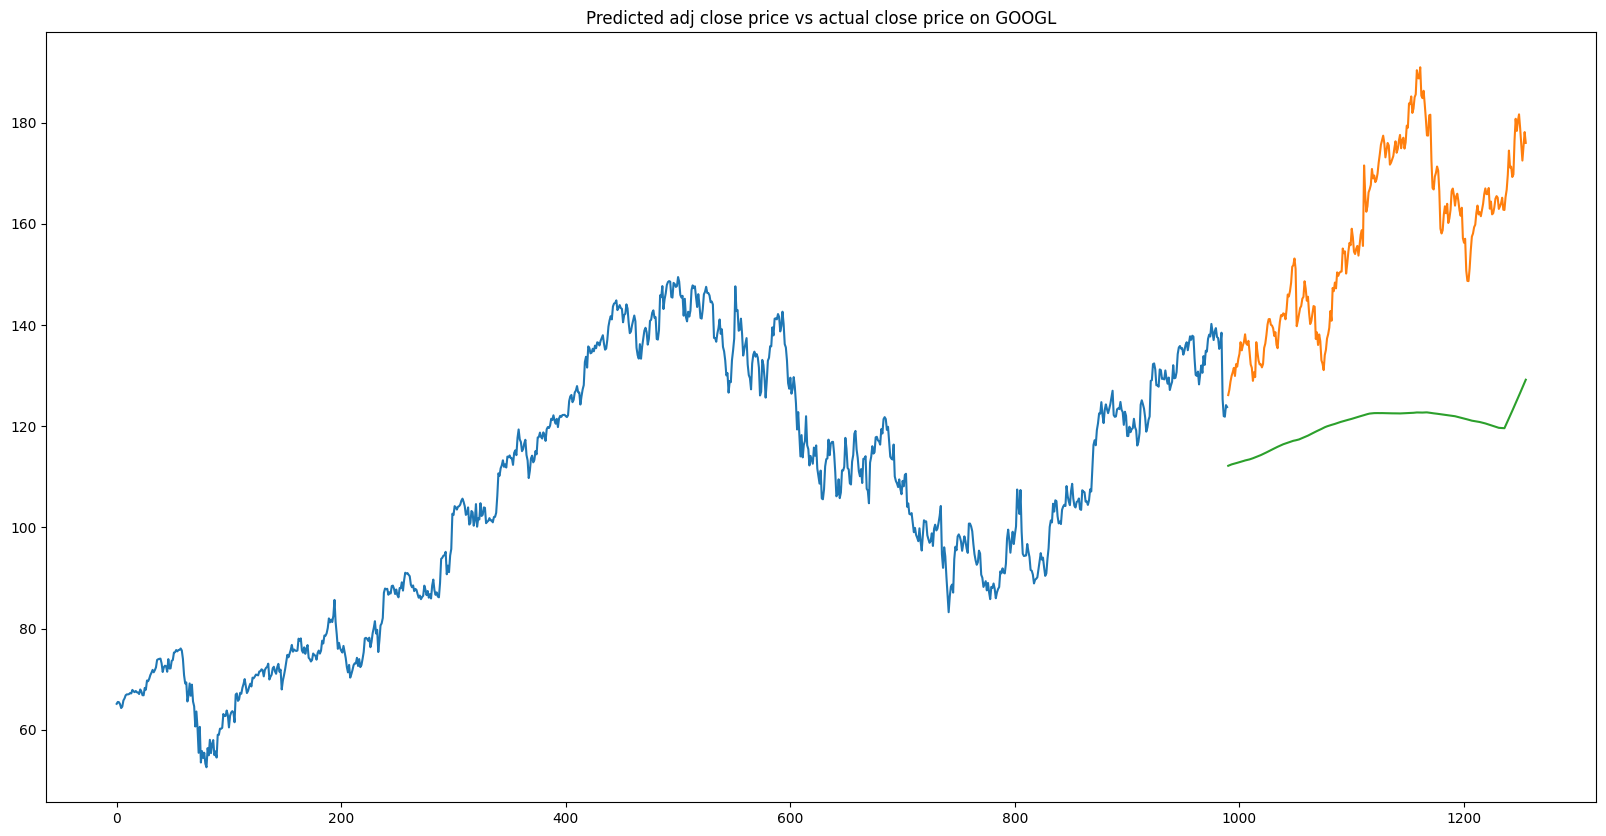

In [6]:
stock.index=stock['Date']

stock_df = stock.sort_index(ascending=True, axis=0)
stock_new = pd.DataFrame(index=range(0, len(stock)), columns=['Date', 'Adj Close'])

for i in range(0,len(stock_df)):
    stock_new['Date'][i] = stock_df['Date'][i]
    stock_new['Adj Close'][i] = stock_df['Adj Close'][i]

#splitting training and validation dataset
train = stock_new[:990]
valid = stock_new[990:]

model = MovingAveragePredictor()
model.fit(train["Adj Close"])
preds = model.predict(valid["Adj Close"])

# checking the results (RMSE value)
rmse = root_mean_squared_error(valid['Adj Close'], preds)
mae = mean_absolute_error(valid['Adj Close'], preds)
r2 = r2_score(valid['Adj Close'], preds)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2}\n')

#plot
valid=valid.copy()
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.title(f'Predicted adj close price vs actual close price on {stock_name}')

save_sklearn_model("MA", model)
update_model_loss("MA", rmse, mae, r2)

# 3. k-Nearest Neighbors

In [7]:
# Convert 'Date' column to datetime type
stock_new['Date'] = pd.to_datetime(stock_new['Date'])

# Remove timezone information before conversion
stock_new['Date'] = stock_new['Date'].dt.tz_localize(None).astype('datetime64[ns]')

# Perform other operations after conversion
stock_new["Year"] = stock_new['Date'].dt.year
stock_new["Month"] = stock_new['Date'].dt.month
stock_new["Day"] = stock_new['Date'].dt.day
stock_new["DayOfWeek"] = stock_new['Date'].dt.dayofweek
stock_new["DayOfYear"] = stock_new['Date'].dt.dayofyear

# Drop the 'Date' column after extracting information
stock_new.drop('Date', axis=1, inplace=True)

Model Fitted!
RMSE: 47.42214862245215
MAE: 44.54308175144339
R2: -7.320330165518163

Saved model to .\models\GOOGL\KNN.pkl


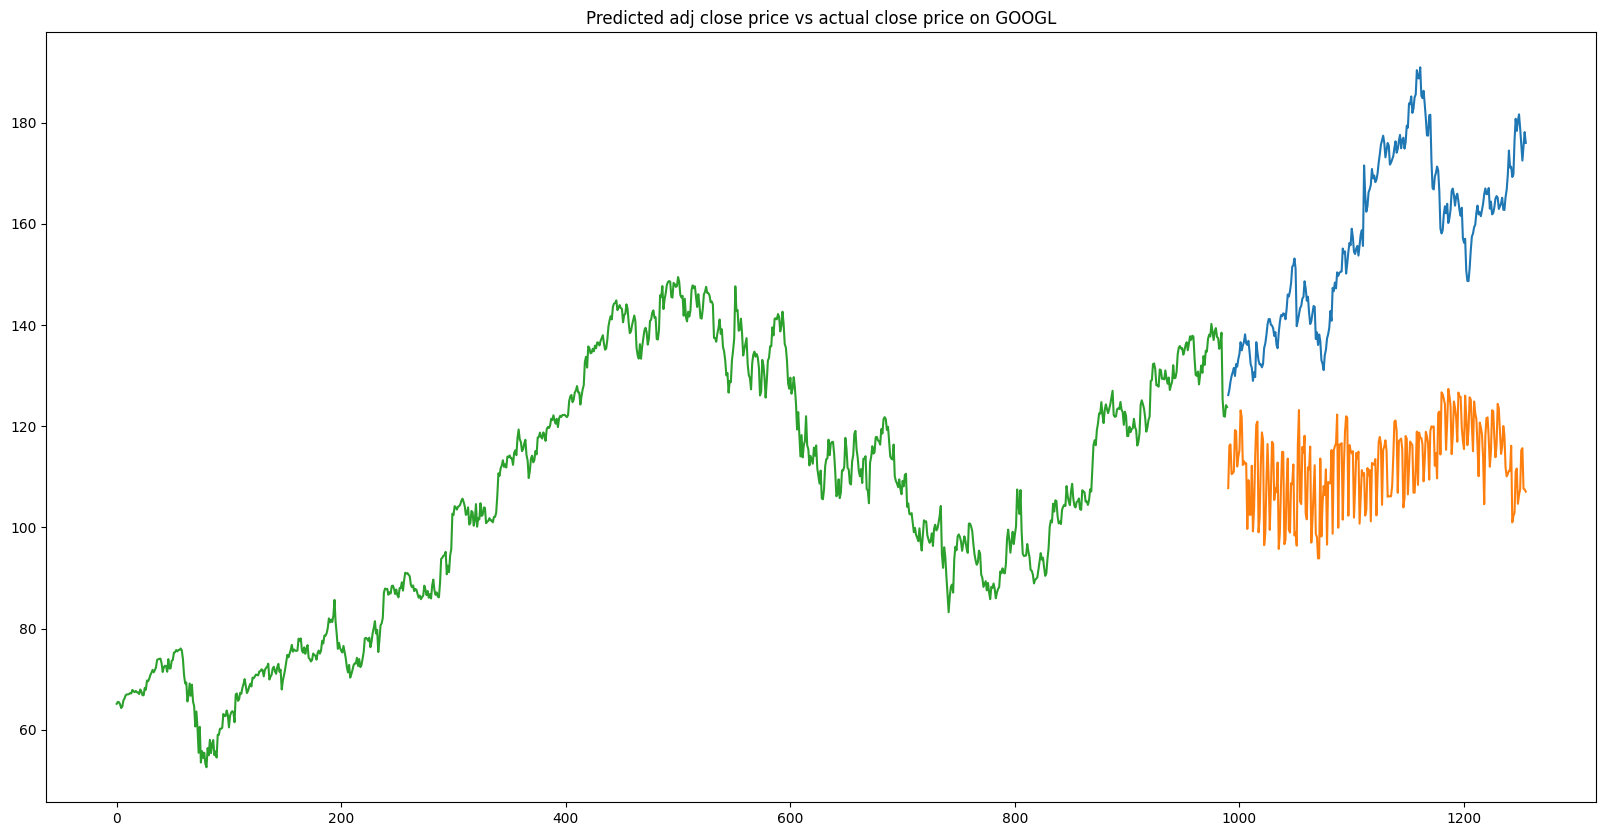

In [8]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

#split into train and validation
train = stock_new[:990]
valid = stock_new[990:]

x_train = train.drop('Adj Close', axis=1)
y_train = train['Adj Close']
x_valid = valid.drop('Adj Close', axis=1)
y_valid = valid['Adj Close']

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)
print('Model Fitted!')

#rmse
rmse = root_mean_squared_error(y_valid, preds)
mae = mean_absolute_error(y_valid, preds)
r2 = r2_score(y_valid, preds)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2}\n')

#plot
valid = valid.copy()
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(valid[['Adj Close', 'Predictions']])
plt.plot(train['Adj Close'])
plt.title(f'Predicted adj close price vs actual close price on {stock_name}')

save_sklearn_model("KNN", model)
update_model_loss("KNN", rmse, mae, r2)

# 4. Linear Regression (Mô hình tuyến tính)

Model Fitted!
RMSE: 28.65281574625724
MAE: 25.111162208413834
R2: -2.0374750529051613

Saved model to .\models\GOOGL\LR.pkl


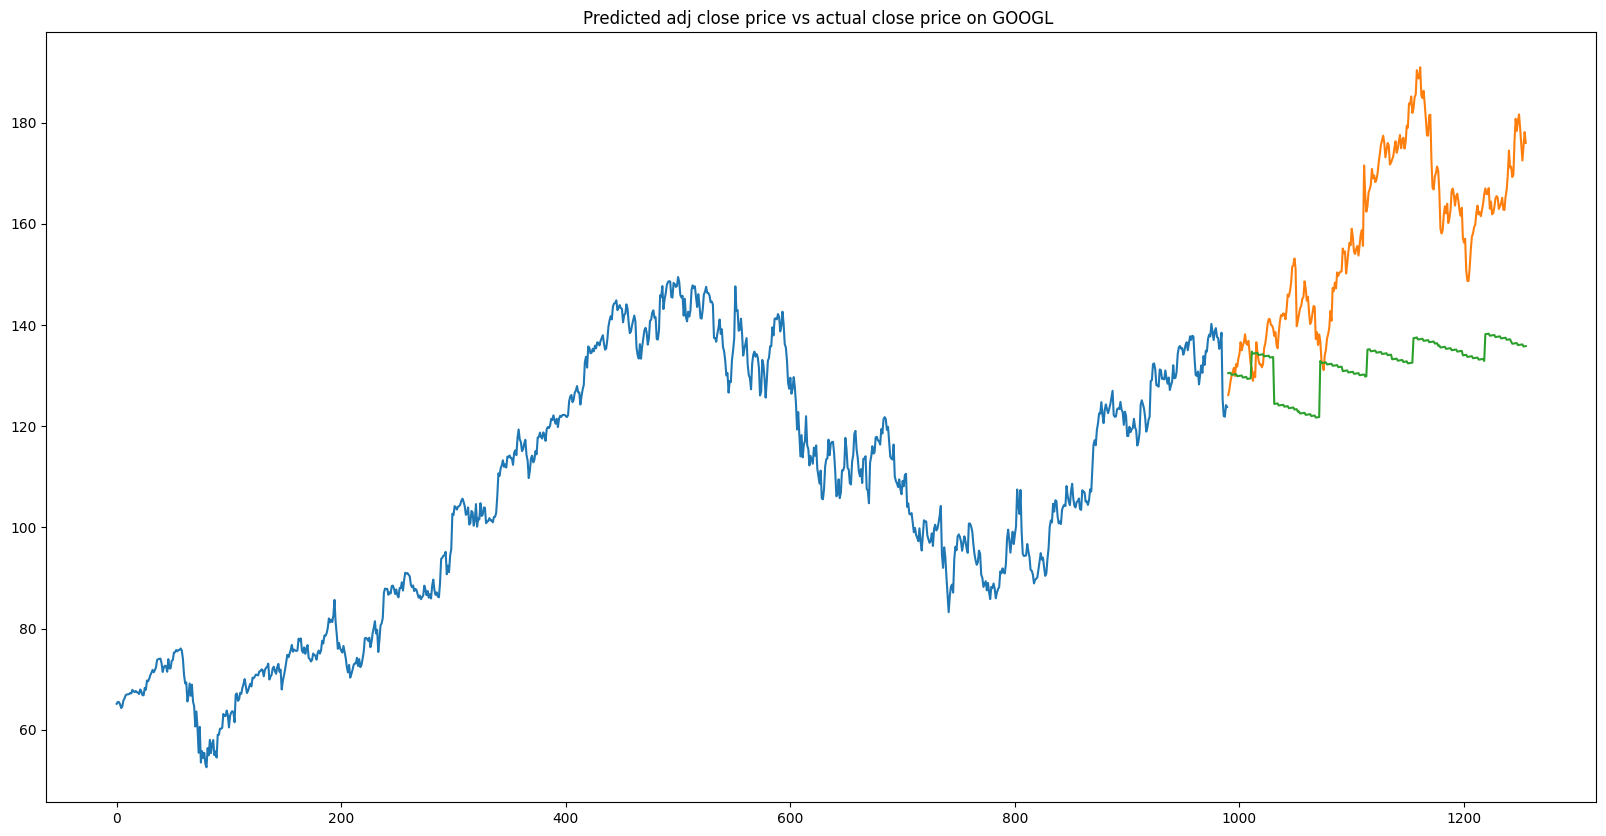

In [9]:
#split into train and validation
train = stock_new[:990]
valid = stock_new[990:]

x_train = train.drop('Adj Close', axis=1)
y_train = train['Adj Close']
x_valid = valid.drop('Adj Close', axis=1)
y_valid = valid['Adj Close']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)
print('Model Fitted!')

#make predictions and find the rmse
preds = model.predict(x_valid)
rmse = root_mean_squared_error(y_valid, preds)
mae = mean_absolute_error(y_valid, preds)
r2 = r2_score(y_valid, preds)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2}\n')

#plot
valid = valid.copy()
valid['Predictions'] = 0
valid['Predictions'] = preds

valid.index = stock_new[990:].index
train.index = stock_new[:990].index

plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.title(f'Predicted adj close price vs actual close price on {stock_name} ')

save_sklearn_model("LR", model)
update_model_loss("LR", rmse, mae, r2)

# 5. LSTM

910/910 - 18s - 19ms/step - loss: 0.0028
Fitting Model
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
RMSE: 4.6612852252573544
MAE: 3.5489341621112107
R2: 0.9196123480796814



Saved model to .\models\GOOGL\LSTM.h5


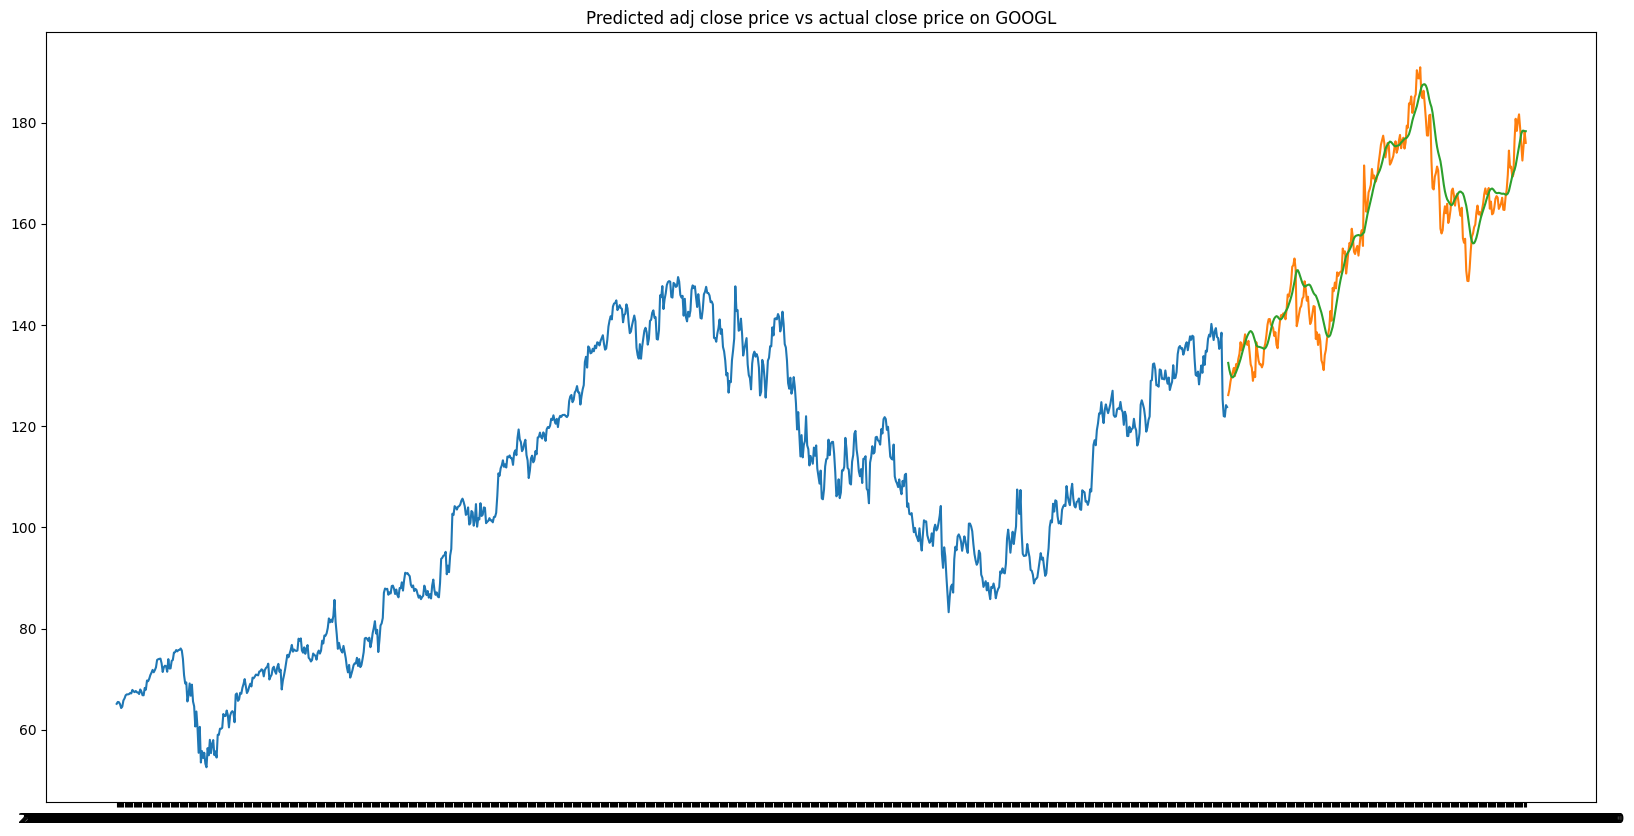

In [10]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

PAST_RANGE = 80

#creating dataframe
stock_lstm = pd.DataFrame(index=range(0,len(stock_df)),columns=['Date', 'Adj Close'])
for i in range(0,len(stock_df)):
    stock_lstm['Date'][i] = stock_df['Date'][i]
    stock_lstm['Adj Close'][i] = stock_df['Adj Close'][i]

#setting index
stock_lstm.index = stock_lstm.Date
stock_lstm.drop('Date', axis=1, inplace=True)


#creating train and test sets
dataset = stock_lstm.values

train = dataset[0:990,:]
valid = dataset[990:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(PAST_RANGE,len(train)):
    x_train.append(scaled_data[i-PAST_RANGE:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
print('Fitting Model')
#predicting 246 values, using past 60 from the train data
inputs = stock_lstm[len(stock_lstm) - len(valid) - PAST_RANGE:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(PAST_RANGE,inputs.shape[0]):
    X_test.append(inputs[i-PAST_RANGE:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
preds = scaler.inverse_transform(closing_price)

rmse = root_mean_squared_error(y_valid, preds)
mae = mean_absolute_error(y_valid, preds)
r2 = r2_score(y_valid, preds)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2}\n')

#for plotting
train = stock_lstm[:990]
valid = stock_lstm[990:]
valid['Predictions'] = preds
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close','Predictions']])
plt.title(f'Predicted adj close price vs actual close price on {stock_name}')

save_keras_model("LSTM", model)
update_model_loss("LSTM", rmse, mae, r2)

scaler_path = os.path.join(stock_model_dir, "LSTM_scaler.pkl")
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)